In [1]:
library(readr) ## importing
library(tidyverse) ## basics
library(lme4) ## linear mixed effect models
library(afex) ## p values for lme4

── Attaching packages ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ dplyr   1.0.7
✔ tibble  3.1.4     ✔ stringr 1.4.0
✔ tidyr   1.1.3     ✔ forcats 0.5.1
✔ purrr   0.3.4     

── Conflicts ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


************
Welcome to afex. For support visit: http://afe

## Differential abundance using ANCOM2

In [2]:
# load taxonomy
otu_data = read_tsv("/Users/dagmarschierova/MEGA/IMG/study_5_revisions/qiime2_results/taxonomy_no_raref/taxonomy-L7-rel-phenotype-WTKO.tsv", skip = 1)
otu_id = otu_data$`#OTU ID`
otu_data = data.frame(otu_data[, -1], check.names = FALSE)
rownames(otu_data) = otu_id

# load metadata
meta_data = read_tsv("/Users/dagmarschierova/MEGA/IMG/study_5_revisions/qiime2_results/metadata.tsv")[-1, ]
meta_data = meta_data %>% rename(Sample.ID = `SampleID`)

#source("https://raw.githubusercontent.com/FrederickHuangLin/ANCOM/master/scripts/ancom_v2.1.R")
source("/Users/dagmarschierova/MEGA/MBÚ/TNF/NGS/scripts/Ancom_paired_modif.R")

Rows: 61 Columns: 28

── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (1): #OTU ID
dbl (27): I-KO-1, I-KO-2, I-KO-3, I-KO-4, I-WT-1, I-WT-2, I-WT-3, I-WT-4, II...


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Rows: 41 Columns: 19

── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (11): SampleID, Label1, Label2, Experiment, FMT_batch, FMT_batch_type, L...
dbl  

In [3]:
# Step 1: Data preprocessing

feature_table = otu_data; sample_var = "Sample.ID"; group_var = "Genotype"
out_cut = 0.05; zero_cut = 0.90; lib_cut = 0; neg_lb = TRUE
prepro = feature_table_pre_process(feature_table, meta_data, sample_var, group_var, 
                                   out_cut, zero_cut, lib_cut, neg_lb)
feature_table = prepro$feature_table # Preprocessed feature table
meta_data = prepro$meta_data # Preprocessed metadata
struc_zero = prepro$structure_zeros # Structural zero info

In [4]:
# Step 2: ANCOM
main_var = "Genotype"; p_adj_method = "BH"; alpha = 0.05
adj_formula = NULL; rand_formula = "~ 1 | Litter"
control = lmeControl(maxIter = 100, msMaxIter = 100, opt = "optim")
t_start = Sys.time()
res = ANCOM(feature_table, meta_data, struc_zero, main_var, p_adj_method, 
            alpha, adj_formula, rand_formula, control = control)
t_end = Sys.time()
t_run = t_end - t_start # around 30s

write.table(res$out, file="/Users/dagmarschierova/MEGA/IMG/study_5_revisions/statistic_results/ANCOM2_L7-rel-Phenotype-WTKO.tsv",
           quote=FALSE, sep='\t', row.names = FALSE)
write.table(res$dat_fig, file="/Users/dagmarschierova/MEGA/IMG/study_5_revisions/statistic_results/ANCOM2_L7-rel-datfig-Phenotype-WTKOtsv",
           quote=FALSE, sep='\t', row.names = FALSE)

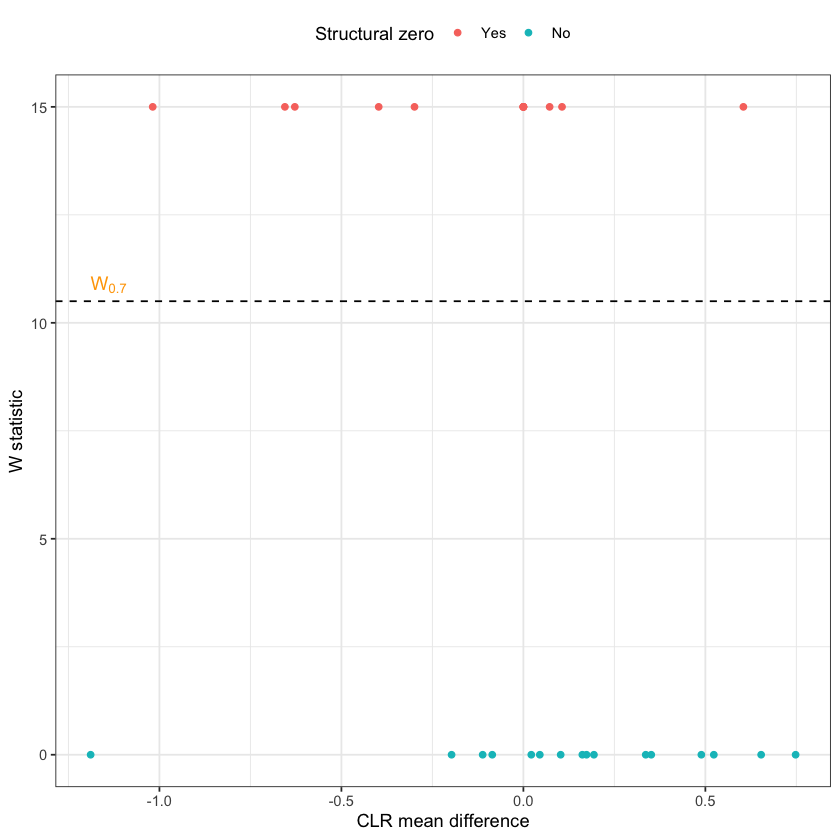

In [5]:
# Step 3: Volcano Plot

# Number of taxa except structural zeros
n_taxa = ifelse(is.null(struc_zero), nrow(feature_table), sum(apply(struc_zero, 1, sum) == 0))
# Cutoff values for declaring differentially abundant taxa
cut_off = c(0.9 * (n_taxa -1), 0.8 * (n_taxa -1), 0.7 * (n_taxa -1), 0.6 * (n_taxa -1))
names(cut_off) = c("detected_0.9", "detected_0.8", "detected_0.7", "detected_0.6")

# Annotation data
dat_ann = data.frame(x = min(res$fig$data$x), y = cut_off["detected_0.7"], label = "W[0.7]")

fig = res$fig + 
  geom_hline(yintercept = cut_off["detected_0.7"], linetype = "dashed") + 
  geom_text(data = dat_ann, aes(x = x, y = y, label = label), 
            size = 4, vjust = -0.5, hjust = 0, color = "orange", parse = TRUE)
fig

## Differential abundance using LMEM with FDR correction

In [6]:
# load metadata
metadata = read_tsv("/Users/dagmarschierova/MEGA/IMG/study_5_revisions/qiime2_results/metadata.tsv")

# load taxonomy
tax_data = read_tsv("/Users/dagmarschierova/MEGA/IMG/study_5_revisions/qiime2_results/taxonomy_no_raref/taxonomy-L7-rel-phenotype-filtered1perc-cutnames.tsv", skip = 1)
tax_id = tax_data$`#OTU ID`
tax_data = data.frame(tax_data[, -1], check.names = FALSE)
rownames(tax_data) = tax_id
tax_data <- t(tax_data)

# merge alpha diversity with metadata
tax_data <- merge(tax_data, metadata, by.x=0, by.y=c("SampleID"))

# filter dataframe
tax_data_g3 <- filter(tax_data, Genotype=="KO" | Genotype=="WT" | Genotype=="KO_IL17")
tax_data_g2_wtko <- filter(tax_data, Genotype=="KO" | Genotype=="WT")
tax_data_g2_wtko17 <- filter(tax_data, Genotype=="WT" | Genotype=="KO_IL17")
tax_data_g2_koko17 <- filter(tax_data, Genotype=="KO" | Genotype=="KO_IL17")


Rows: 41 Columns: 19

── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (11): SampleID, Label1, Label2, Experiment, FMT_batch, FMT_batch_type, L...
dbl  (7): Barcode, Litter_num, Survival_day, Death, Weight_D3, Histo_score_I...
lgl  (1): Sex


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Rows: 27 Columns: 34

── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (1):

In [7]:
## Test differential abundance 2 groups (WT vs KO)
taxa <- seq_along(tax_data_g2_wtko)[2:28]
pvals<-as.numeric()

# apply LMEM on each taxon and store pval
for (taxon in taxa)
{
  model <- lmer(tax_data_g2_wtko[,taxon]~tax_data_g2_wtko$Genotype+(1|tax_data_g2_wtko$Litter))
  pvals[taxon]<-anova(model)[1,6]
  assign(paste0("model_", taxon), model)
}

# correct for multiple hypothesis testing
fdr <- p.adjust(pvals, "fdr")

# organize results in a table
table_wtko<-data.frame(Taxa=colnames(tax_data_g2_wtko)[2:28], n=taxa, p_values=pvals[-1], FDR=fdr[-1])
table_wtko
write.table(table_wtko,"/Users/dagmarschierova/MEGA/IMG/study_5_revisions/statistic_results/LMEM_WTKO.tsv",
            row.names = F, quote = F, sep="\t")

boundary (singular) fit: see ?isSingular



Taxa,n,p_values,FDR
<chr>,<int>,<dbl>,<dbl>
Unassigned_,2,0.8616849,0.9866193
g_Corynebacterium_s_variabile,3,0.3085906,0.8706895
g_Bifidobacterium_,4,0.3401802,0.8706895
g_Bacteroides_,5,0.6693203,0.9035825
g_Parabacteroides_s_,6,0.7343696,0.9441895
g_Parabacteroides_s_distasonis,7,0.2869873,0.8706895
f_Rikenellaceae_g_s_,8,0.3547254,0.8706895
o_Bacteroidales_f_S24_7_g_s_,9,0.1845198,0.8706895
g_Enterococcus_,10,0.8072801,0.9866193


In [8]:
## Test differential abundance 2 groups (WT vs KO+IL-17)
taxa <- seq_along(tax_data_g2_wtko17)[2:28]
pvals<-as.numeric()

# apply LMEM on each taxon and store pval
for (taxon in taxa)
{
  model <- lmer(tax_data_g2_wtko17[,taxon]~tax_data_g2_wtko17$Genotype+(1|tax_data_g2_wtko17$Litter))
  pvals[taxon]<-anova(model)[1,6]
  assign(paste0("model_", taxon), model)
}

# correct for multiple hypothesis testing
fdr <- p.adjust(pvals, "fdr")

# organize results in a table
table_wtko17<-data.frame(Taxa=colnames(tax_data_g2_wtko17)[2:28], n=taxa, p_values=pvals[-1], FDR=fdr[-1])
table_wtko17

write.table(table_wtko17,"/Users/dagmarschierova/MEGA/IMG/study_5_revisions/statistic_results/LMEM_WTKO17.tsv",
            row.names = F, quote = F, sep="\t")

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



Taxa,n,p_values,FDR
<chr>,<int>,<dbl>,<dbl>
Unassigned_,2,0.888817516,0.9474270
g_Corynebacterium_s_variabile,3,0.626068969,0.9474270
g_Bifidobacterium_,4,0.125572359,0.9474270
g_Bacteroides_,5,0.828765765,0.9474270
g_Parabacteroides_s_,6,0.918549399,0.9474270
g_Parabacteroides_s_distasonis,7,0.921870093,0.9474270
f_Rikenellaceae_g_s_,8,0.362460994,0.9474270
o_Bacteroidales_f_S24_7_g_s_,9,0.247242302,0.9474270
g_Enterococcus_,10,0.569739616,0.9474270


In [9]:
## Test differential abundance 2 groups (KO vs KO+IL-17)
taxa <- seq_along(tax_data_g2_koko17)[2:28]
pvals<-as.numeric()

# apply LMEM on each taxon and store pval
for (taxon in taxa)
{
  model <- lmer(tax_data_g2_koko17[,taxon]~tax_data_g2_koko17$Genotype+(1|tax_data_g2_koko17$Litter))
  pvals[taxon]<-anova(model)[1,6]
  assign(paste0("model_", taxon), model)
}

# correct for multiple hypothesis testing
fdr <- p.adjust(pvals, "fdr")

# organize results in a table
table_koko17<-data.frame(Taxa=colnames(tax_data_g2_koko17)[2:28], n=taxa, p_values=pvals[-1], FDR=fdr[-1])
table_koko17

Warning message in vcov.merMod(model):
“Computed variance-covariance matrix problem: not a positive definite matrix;
returning NA matrix”


ERROR: Error in asMethod(object): not a positive definite matrix
